<h1 align="center">Assignment 1</h1> 

#### Assignment Aim
Explore and predict the length of stay of the patients in the hospital

## Table of Contents

1. [Importing Libraries required](#Import)
2. [Creating Functions for preprocessing](#Functions)
3. [Importing the train and test data](#ImportCsv)
4. [Exploring train data](#Explore)
   * [Exploring few observations](#head)
   * [Exploring the attributes of dataframe](#attr)
       * [Exploring the categorical attributes](#cat)
       * [Exploring the numerical attributes](#num)
       * [Exploring the target attributes](#target)
   * [Distribution of the variables](#dist)
       * [Distribution of categorical attributes](#catdist)
       * [Distribution of numerical attributes](#numdist)
   * [Relationship between independent and target attributes](#rel)
       * [Scatter plot for numerical attributes](#relnum)
       * [Correlation Matrix for numerical attributes](#corr)
       * [Bar plot for categorical attributes](#relcat)
   * [Exploring the outliers](#outlier)
   <br>
5. [Splitting the independent and target attribute](#split)
6. [Encoding the categorical attributes](#encode)
7. [Splitting the train data into train, valid and test data](#traintest)
8. [Feature Scaling](#scale)
9. [Performance Metrics](#eval)
10. [Modeling](#m1)
11. [Decision Tree](#m2)
12. [Random Forest](#m3)
13. [Selecting the model](#select)
14. [Predicting for unseen data](#predict)

## 1. Importing Libraries required <a name="Import"></a>

This module deals with importing all the required packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

## 2. Creating Functions<a name="Functions" />

This module deals with the common preprocessing techniques applicable to both training and the unseen data.

In [2]:
def drop_columns(df):
    """This function would set the ID as index and drop the "HealthServiceArea"
    
    :param df - dataframe in which the columns needs to be treated
    :return df - dataframe after preprocessing done
    """
    df.set_index("ID", inplace=True)
    df.drop(columns = ["HealthServiceArea"], inplace=True)
    return df

def change_dtype(df):
    """This function would change the type of CCSProcedureCode to object.
    
    :param df - dataframe in which the columns needs to be treated
    :return df - dataframe after preprocessing done
    """
    df.CCSProcedureCode = df.CCSProcedureCode.astype(object)
    return df

def cleaning_values(df):
    """This function would replace Gender "U" with most commonly occuring gender in the dataframe and 
        PaymentTypology "Unknown" with "Miscellaneous/Other"
    
    :param df - dataframe in which the columns needs to be treated
    :return df - dataframe after preprocessing done
    """
    df_train.drop(df_train[df_train["Gender"] == "U"].index, inplace=True)
    df_train.drop(df_train[df_train["PaymentTypology"] == "Unknown"].index, inplace=True)
    return df

def encoding(df):
    """This function would encode the categorical variables to numerical using one hot encoding technique. And also, the 
       encoder for each attribute is retained, for the test data to be encoded on.
    
    :param df - dataframe in which the columns needs to be treated
    :return df - dataframe after preprocessing done
    """
    ohe_dict = {}
    
    for column in df.select_dtypes(object):
        OHE = OneHotEncoder(handle_unknown='ignore')
        OHE.fit(df[[column]])
        ohe_dict[column] = OHE
        onehot_ = OHE.transform(df[[column]]).toarray()
        for i in range(len(OHE.categories_[0])):
            df[column + '_' + str(OHE.categories_[0][i])] = onehot_[:,i]
    for column in df.select_dtypes(object):
        df.drop(columns = [column], inplace=True)
    return df, ohe_dict

def test_encoding(ohe_dict, df):
    """This function encodes the features of the test data (unseen data) using encoder fitted with the training data.
    
    :param ohe_dict: dictionary of column name and corresponding encoder fitted with training data
    :return: dataframe after encoding
    """
    for column in df.select_dtypes(object):
        onehot_ = ohe_dict[column].transform(df[[column]]).toarray()
        for i in range(len(ohe_dict[column].categories_[0])):
            df[column + '_' + str(ohe_dict[column].categories_[0][i])] = onehot_[:,i]
    for column in df.select_dtypes(object):
        df.drop(columns = [column], inplace=True)
    return df

## 3. Importing the train and test data <a name="ImportCsv" />

In [3]:
df_train = pd.read_csv("Assignment1/train_data.csv")

In [4]:
df_test = pd.read_csv("Assignment1/test_data.csv")

* df_train dataframe has the train dataset, which we will use to do EDA, modelling and then selection of best model for deployment. 
* df_test is the unseen dataset on which the model selected will be applied 

## 4. Exploring Train Data <a name="Explore" />

### 4.1. Exploring few observations <a name="head" />

In [5]:
df_train.head()

,ID,HealthServiceArea,Gender,Race,TypeOfAdmission,CCSProcedureCode,APRSeverityOfIllnessCode,PaymentTypology,BirthWeight,EmergencyDepartmentIndicator,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode,LengthOfStay
0,1,New York City,F,Other Race,Newborn,228,1,Medicaid,3700,N,2611,9227,1751,8951,45,1
1,2,New York City,M,Black/African American,Newborn,228,1,Medicaid,2900,N,3242,8966,3338,6409,34,1
2,3,New York City,M,Other Race,Newborn,220,1,Private Health Insurance,3200,N,3155,11381,4980,9323,45,1
3,4,New York City,F,Other Race,Newborn,0,1,Private Health Insurance,3300,N,3155,11381,5826,15680,59,1
4,5,New York City,F,Other Race,Newborn,228,1,Medicaid,2600,N,2611,9227,6000,14344,59,1


Looking at the data, ID and HealthServiceArea are not attributes required for modeling. Hence these variable can be removed. However, ID can be set as index of the dataframe for faster access of the patient information

In [6]:
#Calling the drop column function defined in section 2
df_train = drop_columns(df_train)

In [7]:
df_train.head(1)

,Gender,Race,TypeOfAdmission,CCSProcedureCode,APRSeverityOfIllnessCode,PaymentTypology,BirthWeight,EmergencyDepartmentIndicator,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode,LengthOfStay
ID,,,,,,,,,,,,,,
1,F,Other Race,Newborn,228,1,Medicaid,3700,N,2611,9227,1751,8951,45,1


Let's explore the data more to see if the columns has any missing values or the data type is incorrect.

### 4.2. Exploring the attributes of the dataframe <a name="attr" />

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59966 entries, 1 to 59966
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Gender                        59966 non-null  object
 1   Race                          59966 non-null  object
 2   TypeOfAdmission               59966 non-null  object
 3   CCSProcedureCode              59966 non-null  int64 
 4   APRSeverityOfIllnessCode      59966 non-null  int64 
 5   PaymentTypology               59966 non-null  object
 6   BirthWeight                   59966 non-null  int64 
 7   EmergencyDepartmentIndicator  59966 non-null  object
 8   AverageCostInCounty           59966 non-null  int64 
 9   AverageChargesInCounty        59966 non-null  int64 
 10  AverageCostInFacility         59966 non-null  int64 
 11  AverageChargesInFacility      59966 non-null  int64 
 12  AverageIncomeInZipCode        59966 non-null  int64 
 13  LengthOfStay    

* Looking at the info of each column, there is no missing value in any of the column and all the columns are in the right data type, except for CCSProcedureCode. 
* CCSProcedureCode needs to be converted to categorical type, as this needs to be encoded before modeling.
* For Analysis purpose, we will convert the APRSeverityOfIllnessCode to object and then will convert back to integer format.

In [9]:
df_train.APRSeverityOfIllnessCode = df_train.APRSeverityOfIllnessCode.astype(object)

In [10]:
#Calling the change_dtype function defined in section 2
df_train = change_dtype(df_train)

In [11]:
df_train.CCSProcedureCode.dtype

dtype('O')

Let's explore the categorical attribute for any interesting insights.

#### 4.2.1 Exploring the categorical attributes <a name="cat" />

In [12]:
for col in df_train.select_dtypes(object):
    print("Column: " + col)
    print(df_train[col].value_counts())
    print("***")

Column: Gender
M    30978
F    28987
U        1
Name: Gender, dtype: int64
***
Column: Race
White                     32943
Other Race                18314
Black/African American     8183
Multi-racial                526
Name: Race, dtype: int64
***
Column: TypeOfAdmission
Newborn      58741
Emergency      659
Urgent         412
Elective       154
Name: TypeOfAdmission, dtype: int64
***
Column: CCSProcedureCode
 228    19886
 115    13628
 0      11189
 220    10773
 231     2981
-1        769
 216      740
Name: CCSProcedureCode, dtype: int64
***
Column: APRSeverityOfIllnessCode
1    47953
2     8760
3     3252
4        1
Name: APRSeverityOfIllnessCode, dtype: int64
***
Column: PaymentTypology
Medicaid                     28723
Private Health Insurance     15608
Blue Cross/Blue Shield       12073
Self-Pay                      1984
Federal/State/Local/VA         849
Managed Care, Unspecified      545
Miscellaneous/Other            118
Medicare                        44
Unknown          

* It seems Gender and Payment Typology has some unknown values. These irregular values can be either treated with replacement or can be dropped from the dataframe. 
* Removing these values would create issues when we are predicting for unseen data, as we cannot remove records from unseen data. 
* The other solution would be to replace them with the most common value.
* Though this is not a optimal solution, this method will be applied as the number of records for this irregular values is pretty less and won't add much value to modeling.
* So for Gender, we will replace "U" with Male as Male is the most common gender in the dataframe and for PaymentTypology, we will replace "Unknown" with Miscellaneous/Other, because PaymentTypology already has a Miscellaneous/Other level, so imputing any unknown as Miscellaneous/Other value would be more logical than replacing it with any other value.
* Also, APRSeverityOfIllness has only one record for level 4, which is of no use as the model won't be learning from this very little information. So we will remove this record for modeling purpose.

In [13]:
#Removing data where the APRSeverityOfIllnessCode is 4.
df_train.drop(df_train[df_train.APRSeverityOfIllnessCode == 4].index, inplace=True)

In [14]:
#Calling the cleaning_values function defined in section 2
df_train = cleaning_values(df_train)

In [15]:
#Rechecking the columns modified.
for column in ["APRSeverityOfIllnessCode","Gender","PaymentTypology"]:
    print("Column:" + column)
    print(df_train[column].value_counts())
    print("****")

Column:APRSeverityOfIllnessCode
1    47939
2     8752
3     3251
Name: APRSeverityOfIllnessCode, dtype: int64
****
Column:Gender
M    30965
F    28977
Name: Gender, dtype: int64
****
Column:PaymentTypology
Medicaid                     28722
Private Health Insurance     15608
Blue Cross/Blue Shield       12072
Self-Pay                      1984
Federal/State/Local/VA         849
Managed Care, Unspecified      545
Miscellaneous/Other            118
Medicare                        44
Name: PaymentTypology, dtype: int64
****


#### 4.2.2 Exploring the numerical attributes <a name="num" />

Let's explore the statistics of the numerical attributes to understand the distribution before looking at it visually.

In [16]:
df_train.loc[:, df_train.columns != "LengthOfStay"].describe()

,BirthWeight,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode
count,59942.000000,59942.000000,59942.000000,59942.000000,59942.000000,59942.000000
mean,3336.356812,2372.612242,7978.207651,2396.701128,7957.201945,59.806396
std,446.245571,639.699564,3220.262938,1248.635801,3859.162481,21.467975
min,2500.000000,712.000000,1243.000000,457.000000,1120.000000,28.000000
25%,3000.000000,2041.000000,4620.000000,1551.000000,4438.000000,45.000000
50%,3300.000000,2533.000000,9227.000000,1967.000000,7945.000000,55.000000
75%,3600.000000,2785.000000,10644.000000,2895.000000,11619.000000,74.000000
max,7500.000000,3242.000000,11381.000000,8114.000000,18466.000000,115.000000


Looking at the statistics of the numerical attributes:
* All the numerical attributes has lot of variance in the data.
* Distribution (range) of each attribute is different, so scaling needs to be done (if any kind of regression model is applied).

#### 4.2.3 Exploring Target Variable <a name="target" />

Let's explore the length of stay of the patients.

In [17]:
df_train.LengthOfStay.value_counts()

2     24991
3     15998
1      8894
4      7494
5      1341
6       557
7       346
8       145
9        97
10       79
Name: LengthOfStay, dtype: int64

For this task, we will assign Length of stay as 0, if the actual stay is 3 days or less and 1, if the stay is more than 3 days.

In [18]:
df_train['LengthOfStay'].replace([0,1,2,3],0, inplace=True)
df_train['LengthOfStay'].replace([4,5,6,7,8,9,10],1, inplace=True)

In [19]:
df_train.LengthOfStay.value_counts()

0    49883
1    10059
Name: LengthOfStay, dtype: int64

Looking at the value counts, it pretty evident that any model built would perform poorly for patients staying for more than 3 days, as there are less number of records for the model to learn from.

### 4.3. Distribution of the variables <a name="dist" />

#### 4.3.1 Distribution of Categorical Attributes <a name="catdist" />

For the categorical variables, let's plot the bar plot to understand the count of each levels in an attribute.

Distribution of categorical variables


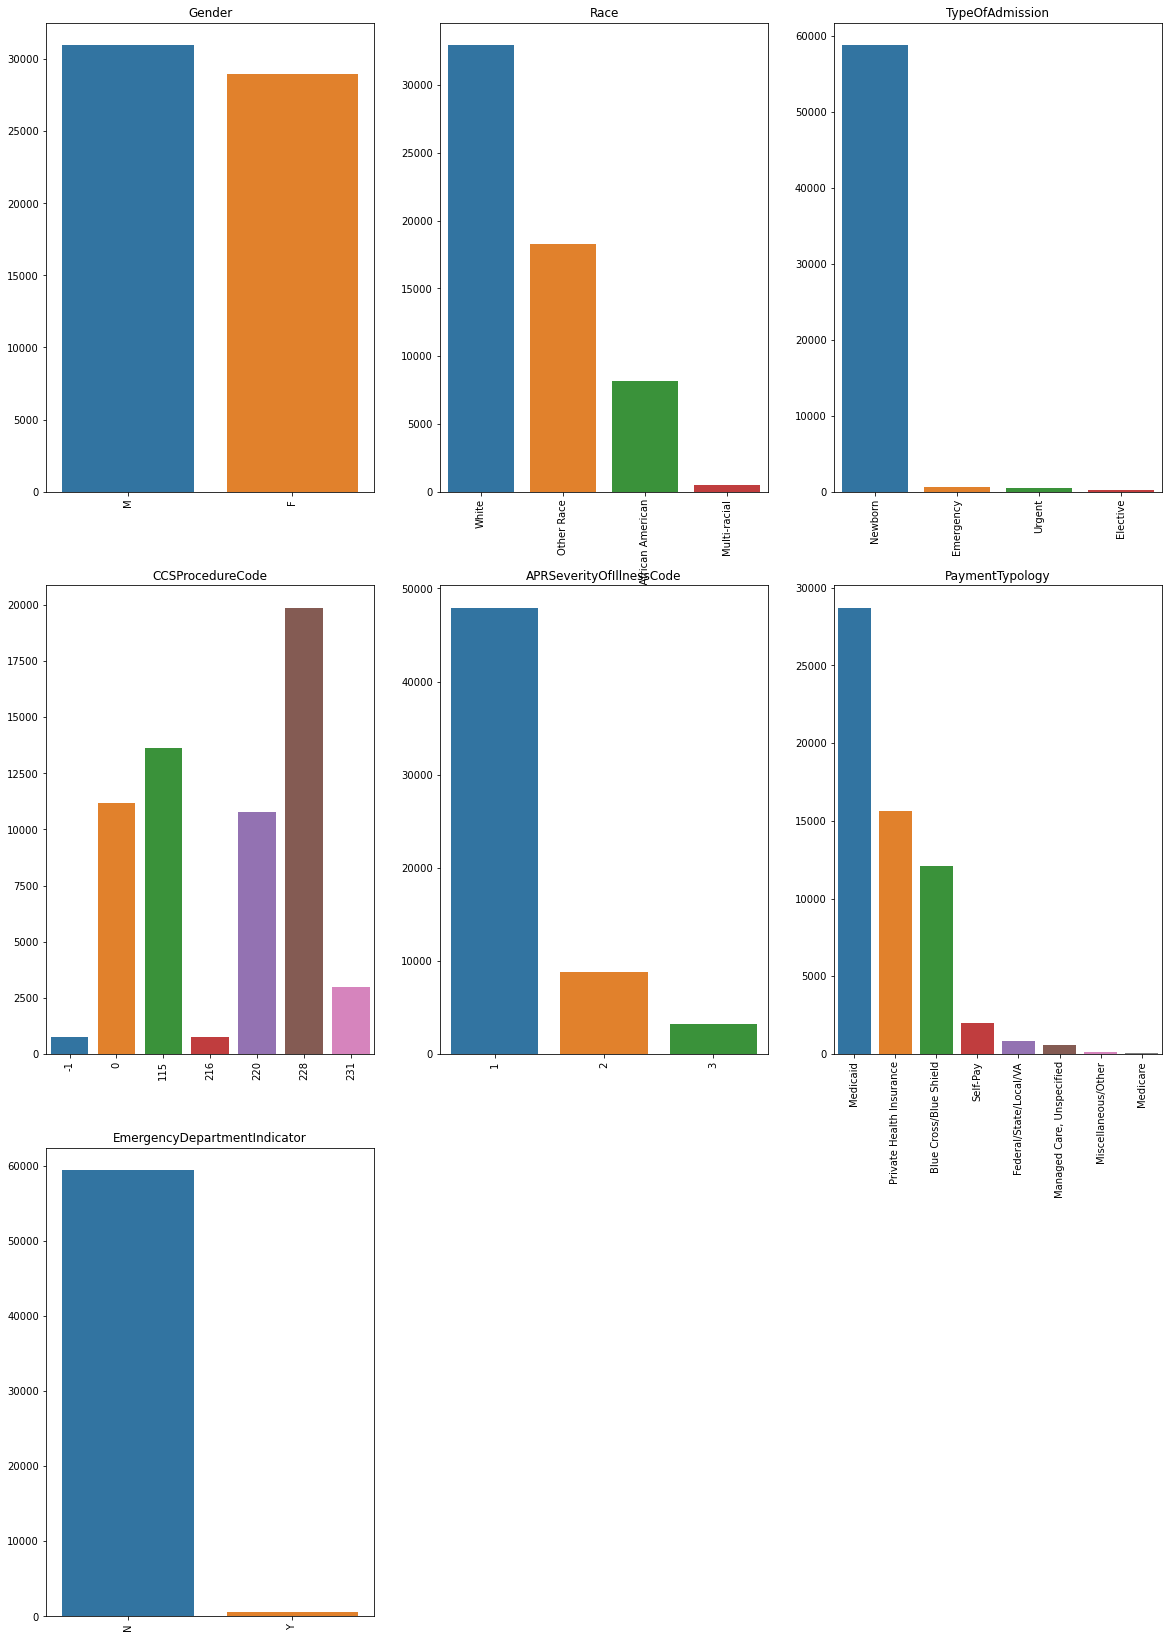

In [20]:
plt.figure(figsize=(20,50))
print("Distribution of categorical variables")
for i, col in enumerate(df_train.select_dtypes(object)):
    plt.subplot(5,3,i+1)
    sns.barplot(x = df_train[col].value_counts().index, y = df_train[col].value_counts().values)
    plt.title(col)
    plt.xticks(rotation='vertical')

* Looking at the distribution of the categorical data, there is discrepancies in the distribution of variables like EmergencyDepartmentIndicator and TypeofAdmission. 
* This means that the model built would predict more accurately when the TypeOfAdmission is "NewBorn" and EmergencyDepartmentIndicator is "N", as there are more training records for the model to learn when this is the scenario.

#### 4.3.2 Distribution of Numerical Attributes <a name="numdist" />

To understand the distribution of the numerical variables let's plot the histogram for the same.

Distribution of numerical variables


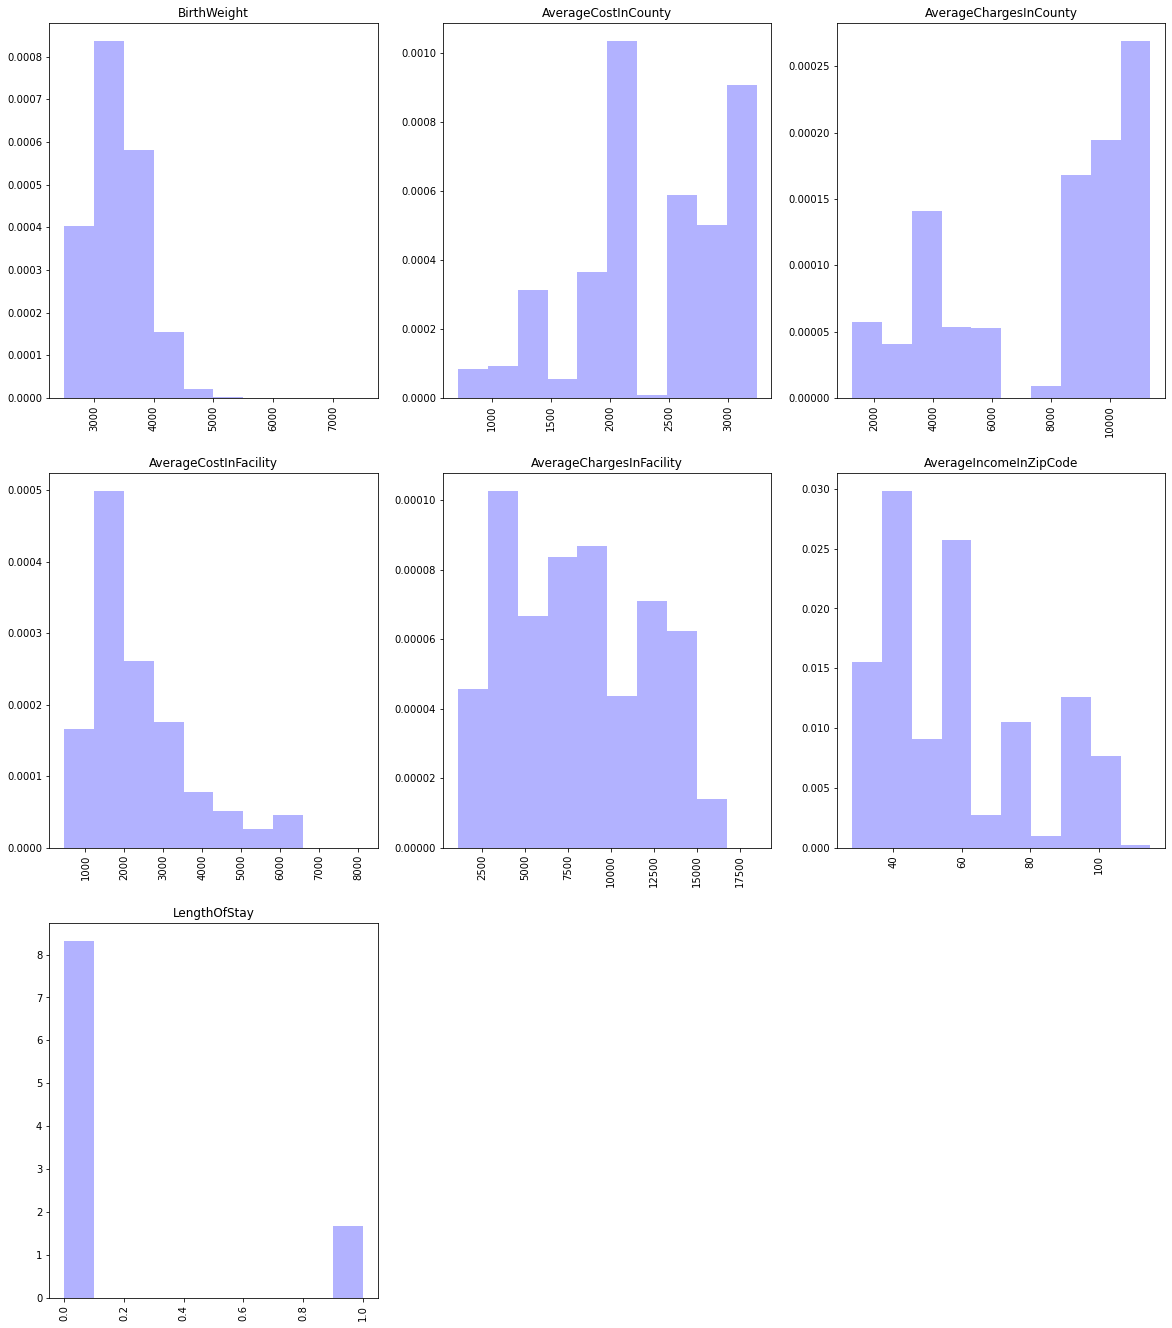

In [21]:
plt.figure(figsize=(20,40))
print("Distribution of numerical variables")
for i, col in enumerate(df_train.select_dtypes("int64")):
    plt.subplot(5,3,i+1)
    plt.hist(df_train[col], alpha=0.3, color='b', density=True)
    plt.title(col)
    plt.xticks(rotation='vertical')

* One clear insight from this distribution is that, the numerical variables have different ranges, which needs to be addressed in the later stage, as this can bring bias in the model. 
* For all the attributes, the data is spread out, which is explained by high variance in the data as seen earlier.
* Also, it seems there might be some level of skewness in the distribution of many attributes. To check this, we will use the skew function and determine on which attribute normalization needs to be applied (if applicable).

In [22]:
for col in df_train.select_dtypes("int64"):
    print("Column: " + col)
    print("Skewness: " + str(df_train[col].skew()))
    print("****")

Column: BirthWeight
Skewness: 0.48100434936461506
****
Column: AverageCostInCounty
Skewness: -0.47346753605027186
****
Column: AverageChargesInCounty
Skewness: -0.6359614828811385
****
Column: AverageCostInFacility
Skewness: 1.2601891029975743
****
Column: AverageChargesInFacility
Skewness: 0.14141658273516008
****
Column: AverageIncomeInZipCode
Skewness: 0.8213128534725345
****
Column: LengthOfStay
Skewness: 1.7778784306676447
****


Skewness exhibited by the attributes are of acceptable range, so there is no need to do power transformation to reduce the skewness.

### 4.4. Relationship between Independent and Target Variable <a name="rel" />

To understand how the indpedent variables are distributed in relationship to target attribute, we will use the pair plot to plot the distribution. This would give us an idea on whether the target feature can be linearly separated or not.
<br>
Note: Since there are lot of features, it's impossible to plot all the features at once and see the relationship with the target feature.

#### 4.4.1 Scatter plot for numerical attributes <rel name="relnum" />

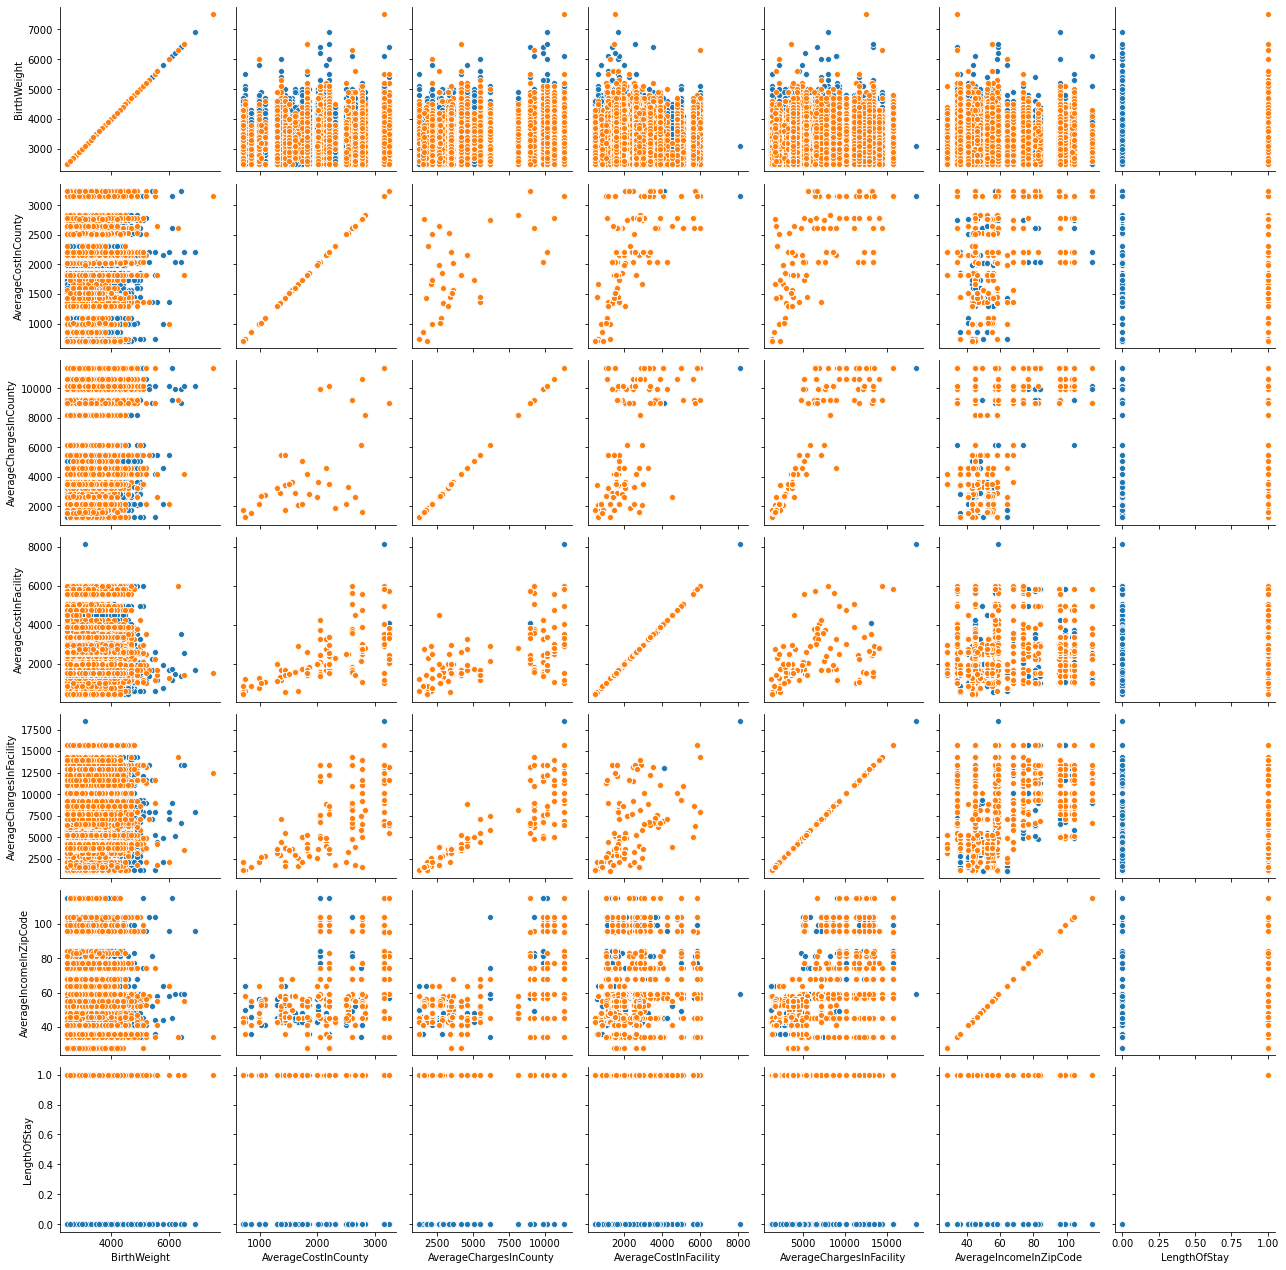

In [23]:
g = sns.PairGrid(df_train, vars= df_train.select_dtypes("int64").columns, hue="LengthOfStay")
g.map(sns.scatterplot)
plt.show()

* The above pair plot doesn't tell any kind of correlation or any sort of linear relationship between the attributes.
* Main insight from the pair plot is that, the target feature cannot be linearly separated. We would need a non-linear boundary to separate the model. 

#### 4.4.2 Correlation matrix for numerical attributes <a name="corr" />

Text(0.5, 1.0, 'Correlation Heatmap')

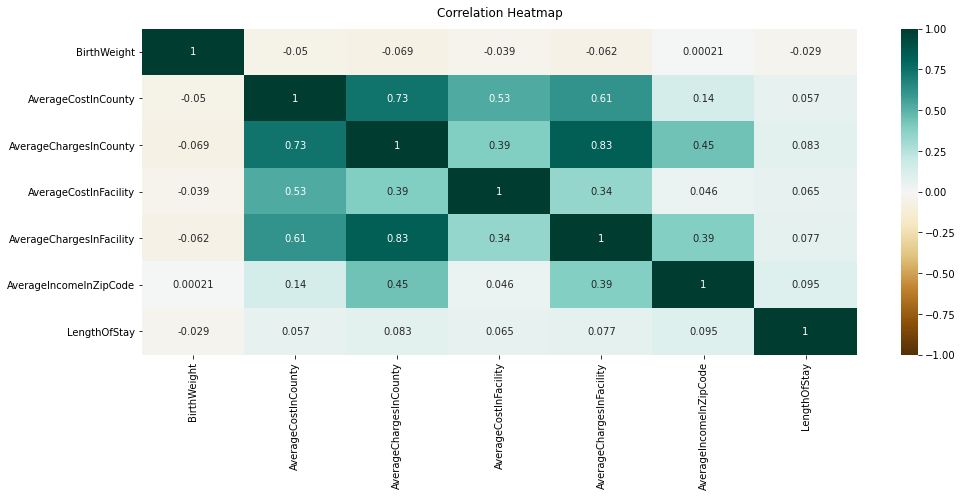

In [24]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', pad=12)

* Well, there's no sort of correlation between the target and independent variables. 
* However, there is correlation to a certain extent between variables - AverageChargesInCountry and AverageCostInCountry, AverageChargeInCountry and AverageChargeInFacility.
* Other than this, most of the attributes exhibit less correlation with each other and with target variable as well.

#### 4.4.3 Bar plot for categorical attributes <a name="relcat" />
Let's explore the relationship between the categorical variables and the target variable

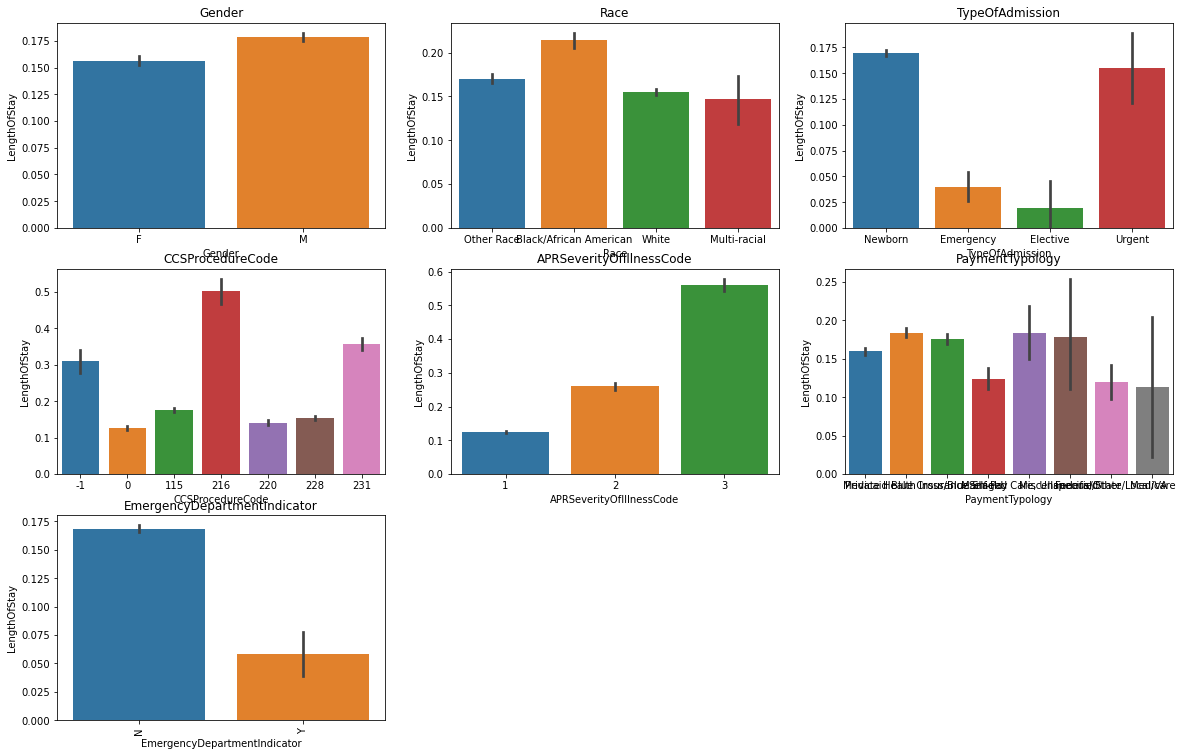

In [25]:
plt.figure(figsize=(20,40))
for i, column in enumerate(df_train.select_dtypes(object)):
    plt.subplot(9,3,i+1)
    sns.barplot(x=column,y='LengthOfStay',data=df_train)
    plt.title(column)

plt.xticks(rotation='vertical')
plt.show()

* For Gender, Race, PaymentTypology, the length of stay remains more or less the same for all the levels of the attributes. 
* For TypeOfAdmission, the length of stay tends to be high for urgent and newborn types. 

### 4.5. Exploring outliers <a name="outlier" />

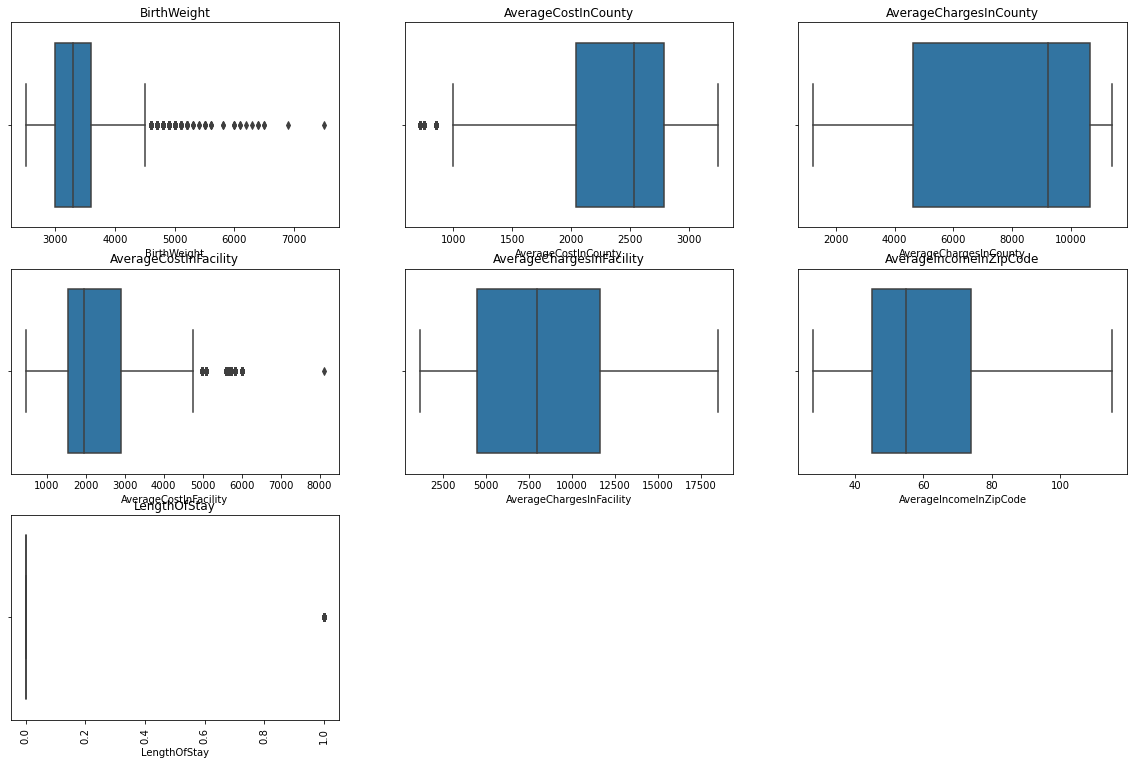

In [26]:
plt.figure(figsize=(20,40))
for i, column in enumerate(df_train.select_dtypes("int64")):
    plt.subplot(9,3,i+1)
    sns.boxplot(x=column,data=df_train)
    plt.title(column)

plt.xticks(rotation='vertical')
plt.show()

* Looking at the outlier for each attribute, only BirthWeight has many outlier values.
* These outliers can be either treated or left alone. For this assignment, the outliers will not be treated.
* The reason for not treating the outliers is because, for example, there are newborn babies who are in general born underweight or overweight, which needs immediate care for which the length of stay might be extended. So if we treat these outlier values, they may affect the length of stay. Instead keeping them, would allow the model to learn and predict more accurately for these kind of conditions.
* Also, for AverageCostInFacility outlier values need not be treated for the very same fact. For example, if the average cost in a particular facility is too expensive for a patient, then the patient would tend to leave the hospital at the earliest. These kinds of scenarios are good for the model to learn.
* One more reason is these values doesn't seem erroneous.

In [27]:
df_train.BirthWeight.describe()

count    59942.000000
mean      3336.356812
std        446.245571
min       2500.000000
25%       3000.000000
50%       3300.000000
75%       3600.000000
max       7500.000000
Name: BirthWeight, dtype: float64

Statistics of birthweight seems normal. However worth noting is that the maximum weight of newborn is 7.5kg which is pretty abnormal as majority of the newborn are less than 4kgs and this is a rare condition.

## 5. Splitting the independent and target variable <a name="split" />

Before we proceed with the modeling, we will segregate the independent and dependent variable.
<br><br>
First, we need to convert the APRSeverityOfIllnessCode to integer type as we changed it for the purpose of analysis.

In [28]:
df_train.APRSeverityOfIllnessCode = df_train.APRSeverityOfIllnessCode.astype(int)

In [29]:
hospital_x = df_train.drop("LengthOfStay", axis=1)
hospital_y = df_train.LengthOfStay 

In [30]:
hospital_x.head(1)

,Gender,Race,TypeOfAdmission,CCSProcedureCode,APRSeverityOfIllnessCode,PaymentTypology,BirthWeight,EmergencyDepartmentIndicator,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode
ID,,,,,,,,,,,,,
1,F,Other Race,Newborn,228,1,Medicaid,3700,N,2611,9227,1751,8951,45


In [31]:
hospital_y.head(1)

ID
1    0
Name: LengthOfStay, dtype: int64

## 6. Encoding the categorical attributes <a name="encode" />

To encode the categorical variable, we will use the one hot encoding technique

In [32]:
#Calling the encoding function defined in section 2.
hospital_x, ohe_dict = encoding(hospital_x)

In [33]:
ohe_dict

{'Gender': OneHotEncoder(handle_unknown='ignore'),
 'Race': OneHotEncoder(handle_unknown='ignore'),
 'TypeOfAdmission': OneHotEncoder(handle_unknown='ignore'),
 'CCSProcedureCode': OneHotEncoder(handle_unknown='ignore'),
 'PaymentTypology': OneHotEncoder(handle_unknown='ignore'),
 'EmergencyDepartmentIndicator': OneHotEncoder(handle_unknown='ignore')}

In [34]:
hospital_x.head()

,APRSeverityOfIllnessCode,BirthWeight,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode,Gender_F,Gender_M,Race_Black/African American,...,PaymentTypology_Blue Cross/Blue Shield,PaymentTypology_Federal/State/Local/VA,"PaymentTypology_Managed Care, Unspecified",PaymentTypology_Medicaid,PaymentTypology_Medicare,PaymentTypology_Miscellaneous/Other,PaymentTypology_Private Health Insurance,PaymentTypology_Self-Pay,EmergencyDepartmentIndicator_N,EmergencyDepartmentIndicator_Y
ID,,,,,,,,,,,,,,,,,,,,,
1,1,3700,2611,9227,1751,8951,45,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,2900,3242,8966,3338,6409,34,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,3200,3155,11381,4980,9323,45,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1,3300,3155,11381,5826,15680,59,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5,1,2600,2611,9227,6000,14344,59,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## 7. Split the train data into train and test <a name="traintest" />

* To split the dataset, we can either use hold out validation or cross validation.
* For this particular task, since the size of the dataset is close to 60,000 records, doing hold out validation split is possible, since there would be good amount of data in the validation and test data, giving enough confidence in the performance of the model.

In [35]:
with pd.option_context('mode.chained_assignment', None):
    hospital_X_train, hospital_X_test, hospital_y_train, hospital_y_test = train_test_split(hospital_x, 
                                                                           hospital_y, test_size=0.25, shuffle=True,
                                                                           random_state=0)

with pd.option_context('mode.chained_assignment', None):
    hospital_X_train, hospital_X_valid, hospital_y_train, hospital_y_valid = train_test_split(hospital_X_train, 
                                                                            hospital_y_train, test_size=0.25, 
                                                                            shuffle=True, random_state=0)

Let's print out the shape of the train, validation and test data to see if the split has correct shape.

In [36]:
print("Size of train data:" + str(hospital_X_train.shape))
print("Size of validation data:" + str(hospital_X_valid.shape))
print("Size of test data:" + str(hospital_X_test.shape))
print("Size of train (Target) data:" + str(hospital_y_train.shape))
print("Size of validation (Target) data:" + str(hospital_y_valid.shape))
print("Size of test (Target) data:" + str(hospital_y_test.shape))

Size of train data:(33717, 34)
Size of validation data:(11239, 34)
Size of test data:(14986, 34)
Size of train (Target) data:(33717,)
Size of validation (Target) data:(11239,)
Size of test (Target) data:(14986,)


To see whether the split has roughly the same distribution, we will overlay the distribution of each variable in 3 different dataset. Train dataset is represented by blue shade, validation by red and test dataset by green.

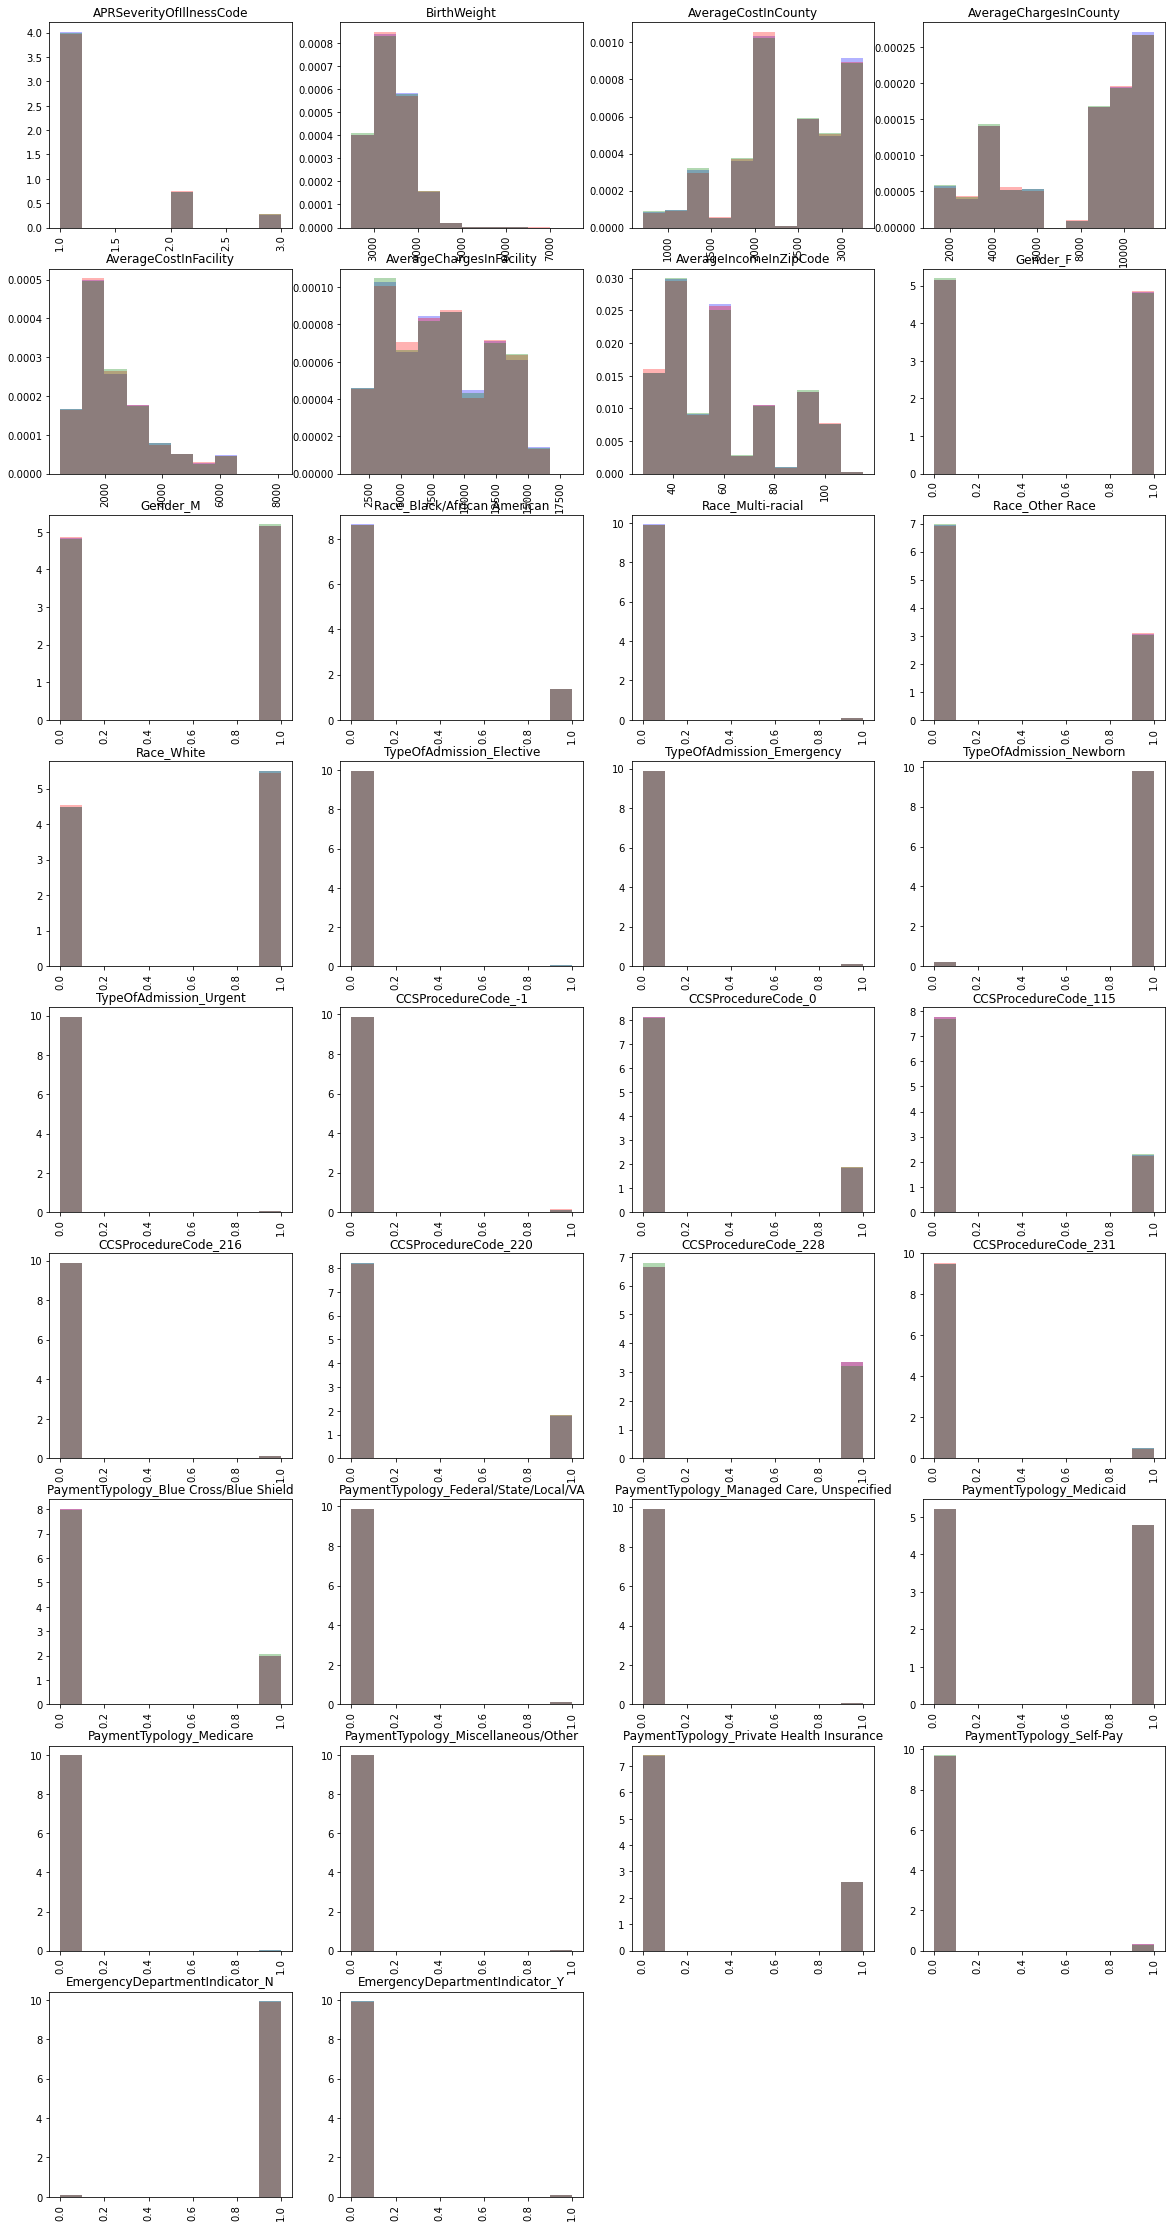

In [37]:
plt.figure(figsize=(20,40))
for i, col in enumerate(hospital_X_train.columns):
    plt.subplot(9,4,i+1)
    _, bins, _ = plt.hist(hospital_X_train[col], alpha=0.3, color='b', density=True)
    plt.hist(hospital_X_valid[col], bins=bins, alpha=0.3, color='r', density=True)
    plt.hist(hospital_X_test[col], bins=bins, alpha=0.3, color='g', density=True)
    plt.title(col)
    plt.xticks(rotation='vertical')

It seems the distribution is almost the same in all the 3 different datasets.

## 8. Feature Scaling <a name="scale" />

Since, in the EDA, it was evident that our dataset won't be separated by the linear boundary for the target feature, we will be using the Decision Tree and Random Forest models to provide a non-linear boundary to separate the target feature. However, since we are proceeding with Decision Tree and Random Forest, there is no need to do scaling, as these models are not influenced by the different ranges of the attribute.

That's why Feature scaling is avoided and normalization to reduce skewness as well.

Let's create the final dataset for the modeling part.

In [38]:
H_train = hospital_X_train.copy()
H_valid = hospital_X_valid.copy()
H_test = hospital_X_test.copy()
t_train = hospital_y_train.copy()
t_valid = hospital_y_valid.copy()
t_test = hospital_y_test.copy()

## 9. Performance Metrics <a name="eval" />

* Since the target feature, in the dataset, has class imbalance problem ( records for patients staying less than 4 days is more than patients staying for more than 4 days), accuracy score is not a good judgement to use.
* For this kind of scenario, we will use the f1 score.
* Since our dataset has the class imbalance issue, we will work with the average="weighted" in the f1_score(), since weighted takes the class imbalance into account, while calculating the score.

In [39]:
def get_f1_scores(clf, train_X, train_y, val_X, val_y):
    """return the f1 score for the model on train and validation data
    
    :param clf: model trained
    :param train_x: train data
    :param train_y: train target data
    :param val_X: validation data
    :param val_y: validataion target data
    : return: f1 score for train data and validation data
    """
    train_pred = clf.predict(train_X)
    val_pred = clf.predict(val_X)
    
    train_f1 = f1_score(train_y, train_pred, average='weighted')
    val_f1 = f1_score(val_y, val_pred, average='weighted')
    
    return train_f1, val_f1

def get_confusion_matrix(clf, test_X, test_y):
    """return the confusion matrix for the test data
    
    :param clf: model trained
    :param test_x: test data
    :param test_y: test target data
    """
    test_pred = clf.predict(test_X)
    
    cm = confusion_matrix(test_y, test_pred)
    
    return cm

def get_f1_test(clf, test_X, test_y):
    """return the accuracy score for the test data
    
    :param clf: model trained
    :param test_x: test data
    :param test_y: test target data
    """
    test_pred = clf.predict(test_X)
    
    test_f1 = f1_score(test_y, test_pred, average='weighted')
    
    return test_f1

## 10. Training the model <a name="m1" />

* Looking at the EDA, there are quite few points which indicates which algorithm to use.
* For this particular classification problem, we will be using Decision Tree and Random Forest.
* Reason:
    * Looking at the EDA, the target feature is not linearly separable, so using any model which needs linearity is eliminated.       So logistic regression, is not good for this problem.
    * Also, looking at the correlation matrix, the independent features (numerical) did not exhibit any linear relationship with the target feature.
    * Since, our dataset contains categorical features as well, the best algorithm suitable for this kind of problems is Decision Tree and Random Forest.

## 11. Decision Tree <a name="m2" />

Initially, we will build the base Decision Tree model with all the default values for parameters and then optimization will be done based on the performance.

In [40]:
clf_DT = DecisionTreeClassifier(random_state=999)
clf_DT = clf_DT.fit(H_train, t_train)

train_f1, val_f1 = get_f1_scores(clf_DT,H_train, t_train, H_valid, t_valid)
print("Train f1 score: {:.3f}".format(train_f1))
print("Validation f1 score: {:.3f}".format(val_f1))

Train f1 score: 0.959
Validation f1 score: 0.771


* Looking at the accuracy score and the f1-score of the model, there seems to be a case of overfitting, which needs to be addressed by changing the parameters of Decision Tree model especially the max_depth.
* Also, there's no need to check the performance of this model on the test data, as it will perform poorly due to overfitting case.
* Since the base model overfits based on the validation data, we will optimize the model by hyper parameter tuning.

In [41]:
#Defining the set of parameters
parameters = {
    'max_depth':[2,4,6,8,10,12,15], 
    'min_samples_split':np.arange(2,50,5),
    'criterion':["gini","entropy"],
    "class_weight":["balanced"]
}

gs_DT = GridSearchCV(estimator=DecisionTreeClassifier(random_state=999), 
                      param_grid=parameters,
                      verbose=1,  # verbose: the higher, the more messages
                      scoring='f1', 
                      return_train_score=True,
                      n_jobs=-1)

In [42]:
gs_DT.fit(H_train, t_train);

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  1.2min finished


In [43]:
gs_DT.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 6,
 'min_samples_split': 2}

In [44]:
gs_DT.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=999)

In [45]:
train_f1, val_f1 = get_f1_scores(gs_DT.best_estimator_, H_train, t_train, H_valid, t_valid)
print("Train F1-Score score: {:.3f}".format(train_f1))
print("Validation F1-Score score: {:.3f}".format(val_f1))

Train F1-Score score: 0.754
Validation F1-Score score: 0.741


In [46]:
print("F1 score on the test data: " + str(get_f1_test(gs_DT.best_estimator_, H_test, t_test)))
print(get_confusion_matrix(gs_DT.best_estimator_, H_test, t_test))

F1 score on the test data: 0.7479790120863795
[[9064 3368]
 [ 868 1686]]


* Looking at the optimized Decision Tree with criterion = "entropy", max_depth = 6, min_samples_split=2, class_weight="balanced", this model's performance on the test data is doing good, giving an f1 score of 0.748 on the test data.
* Also, optimized decision tree is performing better in comparison to base decision tree with no case of overfitting. So the optimized decision tree is chosen to represent the decision tree.
* Also, the confusion matrix shows that the model classifies the patient staying for more than 4 days correctly 66% of the time, considering the imbalance it's a pretty good model.

## 12. Random Forest <a name="m3" />

Initially we will the train the base Random Forest Classifier model and evaluate it's performance.

In [47]:
clf_RF = RandomForestClassifier(random_state=999)
clf_RF.fit(H_train, t_train);

In [48]:
train_f1, val_f1 = get_f1_scores(clf_RF,H_train, t_train, H_valid, t_valid)
print("Train f1 score: {:.3f}".format(train_f1))
print("Validation f1 score: {:.3f}".format(val_f1))

Train f1 score: 0.960
Validation f1 score: 0.790


* Looking at the performance of the Base Random Forest, there's a clear case of overfitting, just like the base decision tree model, which needs to be addressed using the hyper parameter tuning.
* Also, there's no need to look at the performance of the model on test data, as it will clearly overfit.
* Since there is overfitting, we will try to optimize the model by hyper parameter tuning.

In [49]:
parameters = {
    'max_depth':[2,4,6,8,10], 
    'min_samples_split':np.arange(2,10,4),
    'criterion':["gini","entropy"],
    "class_weight":["balanced"],
    "n_estimators":[500]
}

gs_RF = GridSearchCV(estimator=RandomForestClassifier(random_state=999), 
                      param_grid=parameters,
                      verbose=1,  # verbose: the higher, the more messages
                      scoring='f1', 
                      return_train_score=True, 
                      n_jobs=-1)

In [50]:
gs_RF.fit(H_train, t_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.7min finished


In [51]:
gs_RF.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=500,
                       random_state=999)

In [52]:
train_f2, val_f2 = get_f1_scores(gs_RF.best_estimator_, H_train, t_train, H_valid, t_valid)
print("Train F1-Score score: {:.3f}".format(train_f2))
print("Validation F1-Score score: {:.3f}".format(val_f2))


Train F1-Score score: 0.783
Validation F1-Score score: 0.762


In [53]:
print("F1 score on the test data: " + str(get_f1_test(gs_RF.best_estimator_, H_test, t_test)))
print(get_confusion_matrix(gs_RF.best_estimator_, H_test, t_test))

F1 score on the test data: 0.7657992672600381
[[9406 3026]
 [ 877 1677]]


* Looking at the optimized Random Forest, with max_depth = 10, min_samples_split = 2, n_estimators = 500, the performance on the test data is better than the base random forest classifier.
* Optimized Random Forest is better than the base model, as there is no case of overfitting, looking at the f1 scores.
* So this optimized model is chosen to represent the random forest.

## 13. Selecting the model <a name="select" />

Comparison of different model:

1. Optimized Decision Tree - 
     * Parameters: criterion="entropy", max_depth = 6, min_samples_split=2, class_weight="balanced"
     * F1 Score on Train Data - 0.754
     * F1 Score on Validation Data - 0.741
     * F1 Score on Test Data - 0.748
     * Confusion matrix -<br>
     <table>
        <tr>
            <th>Actual/Predicted </th>
            <th>0</th>
            <th>1</th> 
        </tr>  
        <tr>
            <td>0</td> 
            <td>9064</td> 
            <td>3368</td>
        </tr>

        <tr>
            <td>1</td> 
            <td>868</td> 
            <td>1686</td>   
        </tr>

     </table>
     
2. Optimized Random Forest - 
     * Parameters: criterion="gini", max_depth = 10, min_samples_split=2, n_estimators=500
     * F1 Score on Train Data - 0.783
     * F1 Score on Validation Data - 0.762
     * F1 Score on Test Data - 0.765
     * Confusion matrix -<br>
     <table>
        <tr>
            <th>Actual/Predicted </th>
            <th>0</th>
            <th>1</th> 
        </tr>  
        <tr>
            <td>0</td> 
            <td>9406</td> 
            <td>3026</td>
        </tr>

        <tr>
            <td>1</td> 
            <td>877</td> 
            <td>1677</td>   
        </tr>

     </table>

* Looking at the above evaluation metrics of each model trained, both optimized Decision Tree and Opitimized Random Forest gives good result in terms of f1 score and confusion matrix as well.
* However, optimized Random Forest model produces better f1 score on the test data. 
* Looking at the confusion matrix, Random Forest is better in classifying the positive cases, i.e. patients staying for more than 4 days.
* So looking at all the parameters, the optimized random forest works better for this particular task and will be using it for predicting the values for unseen data.

## 14. Predicting for unseen data <a name="predict" />

Before we use the Random Forest Classifier on the unseen data, let's clean the data to make it model ready. For the preprocessing,
1. We will remove the ID and healthservicearea from the dataset
2. Convert the data type of CCSProcedureCode
3. Encode the categorical feature using the same encoder used for the training dataset.
4. Lastly, we will predict the target feature.

In [54]:
df_test.head()

,ID,HealthServiceArea,Gender,Race,TypeOfAdmission,CCSProcedureCode,APRSeverityOfIllnessCode,PaymentTypology,BirthWeight,EmergencyDepartmentIndicator,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode
0,1,New York City,F,Other Race,Newborn,216,3,Medicaid,4900,N,3242,8966,2448,13196,34
1,2,New York City,F,White,Newborn,220,1,Medicaid,3100,N,2611,9227,1751,8951,45
2,3,New York City,M,Multi-racial,Newborn,115,1,Medicaid,3300,N,3155,11381,1052,11314,74
3,4,New York City,M,Other Race,Newborn,228,1,Medicaid,3300,N,2611,9227,3790,6250,45
4,5,New York City,F,Other Race,Newborn,220,2,Medicaid,3800,N,3155,11381,3032,10135,59


In [55]:
df_test = drop_columns(df_test)

In [56]:
df_test = change_dtype(df_test)

In [57]:
df_test = test_encoding(ohe_dict, df_test)

In [58]:
predicted = gs_RF.best_estimator_.predict(df_test)

In [59]:
predicted_df = pd.DataFrame({
    "ID":df_test.index,
    "LengthOfStay":predicted
})

In [60]:
predicted_df.head()

,ID,LengthOfStay
0,1,1
1,2,0
2,3,0
3,4,0
4,5,1


In [61]:
predicted_df["LengthOfStay"].value_counts()

0    55039
1    14138
Name: LengthOfStay, dtype: int64

In [62]:
predicted_df.to_csv("s3797863_predictions.csv", index=False)